In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import ot
import ot.plot

plt.style.use('default')
plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif')
plt.rc('font', size=14)
plt.rc('axes', titlesize=14)
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=14)
plt.rc('lines', markersize=10)

2023-12-19 00:58:12.688805: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-12-19 00:58:12.688825: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-19 00:58:12.688832: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-19 00:58:12.688865: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-19 00:58:12.688880: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/quyenlinhta/IASD/iasd/lib/python3.10/site-packages/ot/backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate i

In [2]:
torch.manual_seed(42)
np.random.seed(42)

n_source_samples = 1000
n_target_samples = 1000
theta = 2 * np.pi / 20
noise_level = 0.1

Xs = np.random.randn(n_source_samples, 2) * 0.5
Xt = np.random.randn(n_target_samples, 2) * 2

# one of the target mode changes its variance (no linear mapping)
Xt = Xt + 4

Text(0.5, 1.0, 'Source and target distributions')

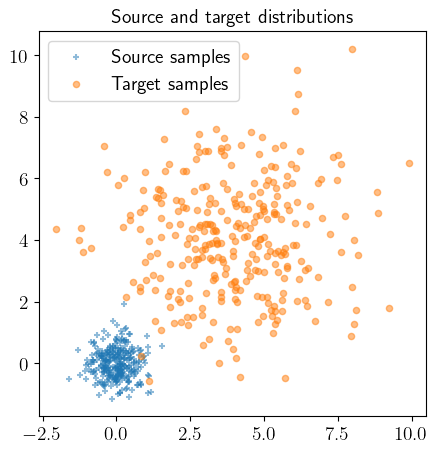

In [3]:
nvisu = 300
plt.figure(1, (5, 5))
plt.clf()
plt.scatter(Xs[:nvisu, 0], Xs[:nvisu, 1], marker='+', label='Source samples', alpha=0.5, s=20)
plt.scatter(Xt[:nvisu, 0], Xt[:nvisu, 1], marker='o', label='Target samples', alpha=0.5, s=20)
plt.legend(loc=0)
ax_bounds = plt.axis()
plt.title('Source and target distributions')

In [4]:
xs = torch.tensor(Xs)
xt = torch.tensor(Xt)

Iter:   0, loss=0.2573297265641152
Iter:  10, loss=-11.890456809932092
Iter:  20, loss=-15.58037953568942
Iter:  30, loss=-18.440996930557937
Iter:  40, loss=-22.12608617577679
Iter:  50, loss=-25.275903436973326
Iter:  60, loss=-27.268827617390617
Iter:  70, loss=-29.79159074521156
Iter:  80, loss=-31.634887311622954
Iter:  90, loss=-32.12722863942374
Iter: 100, loss=-32.696522633664756
Iter: 110, loss=-33.46949403033256
Iter: 120, loss=-32.642069137638316
Iter: 130, loss=-36.15381636088364
Iter: 140, loss=-34.28321242520424
Iter: 150, loss=-35.52058538736675
Iter: 160, loss=-35.676096592160775
Iter: 170, loss=-34.45865441680551
Iter: 180, loss=-34.43596310747665
Iter: 190, loss=-35.261945708084404
Iter: 200, loss=-34.01278968611392
Iter: 210, loss=-36.874011702552764
Iter: 220, loss=-35.12820568885405
Iter: 230, loss=-37.6372243174226
Iter: 240, loss=-35.65926623248377
Iter: 250, loss=-36.52742548735251
Iter: 260, loss=-36.126583693269914
Iter: 270, loss=-31.735871204757427
Iter: 280

Text(0.5, 0, 'Iterations')

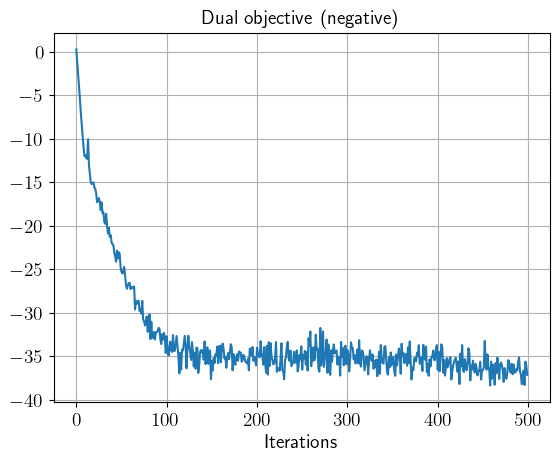

In [5]:
torch.manual_seed(42)


# define the MLP model


class Potential(torch.nn.Module):
    def __init__(self):
        super(Potential, self).__init__()
        self.fc1 = nn.Linear(2, 200)
        self.fc2 = nn.Linear(200, 1)
        self.relu = torch.nn.ReLU()  # instead of Heaviside step fn

    def forward(self, x):
        output = self.fc1(x)
        output = self.relu(output)  # instead of Heaviside step fn
        output = self.fc2(output)
        return output.ravel()


u = Potential().double()
v = Potential().double()

reg = 1

optimizer = torch.optim.Adam(list(u.parameters()) + list(v.parameters()), lr=.005)

# number of iteration
n_iter = 500
n_batch = 500

losses = []

for i in range(n_iter):

    # generate noise samples

    iperms = torch.randint(0, n_source_samples, (n_batch,))
    ipermt = torch.randint(0, n_target_samples, (n_batch,))

    xsi = xs[iperms]
    xti = xt[ipermt]

    # minus because we maximize te dual loss
    loss = -ot.stochastic.loss_dual_entropic(u(xsi), v(xti), xsi, xti, reg=reg)
    losses.append(float(loss.detach()))

    if i % 10 == 0:
        print("Iter: {:3d}, loss={}".format(i, losses[-1]))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

plt.figure(2)
plt.plot(losses)
plt.grid()
plt.title('Dual objective (negative)')
plt.xlabel("Iterations")

/var/folders/sm/lw2bbffs15g5l3r4ldd25hc00000gn/T/ipykernel_68725/1608116767.py:27: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc=0)
/var/folders/sm/lw2bbffs15g5l3r4ldd25hc00000gn/T/ipykernel_68725/1608116767.py:41: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc=0)
/var/folders/sm/lw2bbffs15g5l3r4ldd25hc00000gn/T/ipykernel_68725/1608116767.py:55: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc=0)


Text(0.5, 1.0, 'Density of transported source sample')

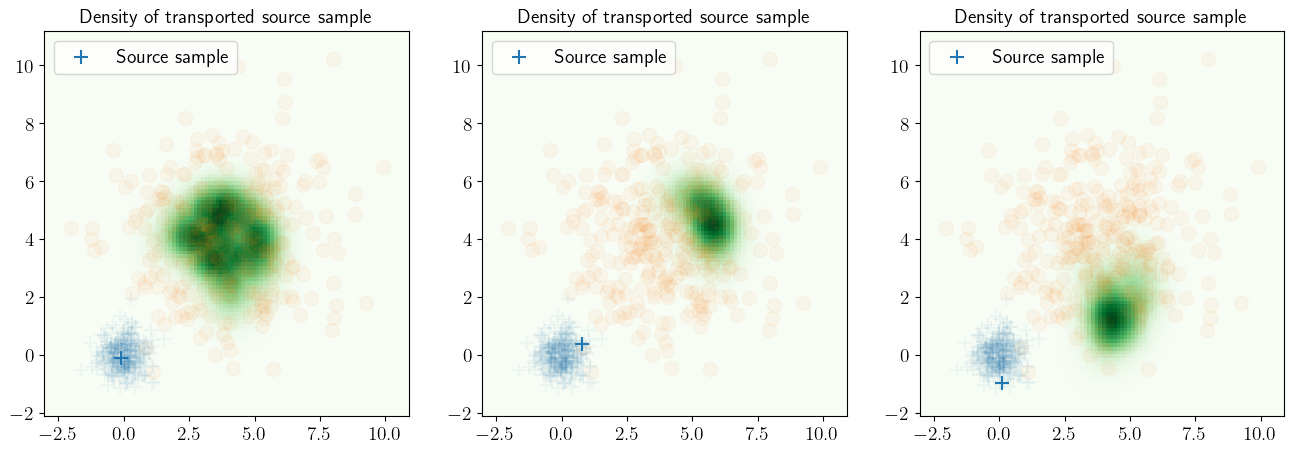

In [11]:
nv = 100
xl = np.linspace(ax_bounds[0], ax_bounds[1], nv)
yl = np.linspace(ax_bounds[2], ax_bounds[3], nv)

XX, YY = np.meshgrid(xl, yl)

xg = np.concatenate((XX.ravel()[:, None], YY.ravel()[:, None]), axis=1)

wxg = np.exp(-((xg[:, 0] - 4) ** 2 + (xg[:, 1] - 4) ** 2) / (2 * 2))
wxg = wxg / np.sum(wxg)

xg = torch.tensor(xg)
wxg = torch.tensor(wxg)

plt.figure(4, (16, 5))
plt.clf()
plt.subplot(1, 3, 1)

iv = 2
Gg = ot.stochastic.plan_dual_entropic(u(xs[iv:iv + 1, :]), v(xg), xs[iv:iv + 1, :], xg, reg=reg, wt=wxg)
Gg = Gg.reshape((nv, nv)).detach().numpy()

plt.scatter(Xs[:nvisu, 0], Xs[:nvisu, 1], marker='+', zorder=2, alpha=0.05)
plt.scatter(Xt[:nvisu, 0], Xt[:nvisu, 1], marker='o', zorder=2, alpha=0.05)
plt.scatter(Xs[iv:iv + 1, 0], Xs[iv:iv + 1, 1], s=100, marker='+', label='Source sample', zorder=2, alpha=1, color='C0')
plt.pcolormesh(XX, YY, Gg, cmap='Greens', label='Density of transported source sample')
plt.legend(loc=0)
ax_bounds = plt.axis()
plt.title('Density of transported source sample')

plt.subplot(1, 3, 2)

iv = 3
Gg = ot.stochastic.plan_dual_entropic(u(xs[iv:iv + 1, :]), v(xg), xs[iv:iv + 1, :], xg, reg=reg, wt=wxg)
Gg = Gg.reshape((nv, nv)).detach().numpy()

plt.scatter(Xs[:nvisu, 0], Xs[:nvisu, 1], marker='+', zorder=2, alpha=0.05)
plt.scatter(Xt[:nvisu, 0], Xt[:nvisu, 1], marker='o', zorder=2, alpha=0.05)
plt.scatter(Xs[iv:iv + 1, 0], Xs[iv:iv + 1, 1], s=100, marker='+', label='Source sample', zorder=2, alpha=1, color='C0')
plt.pcolormesh(XX, YY, Gg, cmap='Greens', label='Density of transported source sample')
plt.legend(loc=0)
ax_bounds = plt.axis()
plt.title('Density of transported source sample')

plt.subplot(1, 3, 3)

iv = 6
Gg = ot.stochastic.plan_dual_entropic(u(xs[iv:iv + 1, :]), v(xg), xs[iv:iv + 1, :], xg, reg=reg, wt=wxg)
Gg = Gg.reshape((nv, nv)).detach().numpy()

plt.scatter(Xs[:nvisu, 0], Xs[:nvisu, 1], marker='+', zorder=2, alpha=0.05)
plt.scatter(Xt[:nvisu, 0], Xt[:nvisu, 1], marker='o', zorder=2, alpha=0.05)
plt.scatter(Xs[iv:iv + 1, 0], Xs[iv:iv + 1, 1], s=100, marker='+', label='Source sample', zorder=2, alpha=1, color='C0')
plt.pcolormesh(XX, YY, Gg, cmap='Greens', label='Density of transported source sample')
plt.legend(loc=0)
ax_bounds = plt.axis()
plt.savefig('figs/ot_stochastic_dual_entropic.pdf', bbox_inches='tight')
plt.title('Density of transported source sample')